# Import Data
First, let's use the pandas library to import the data and store it. It is quite obvious that the first sample is a fluke, and was thus ignored.

In [1]:
## Import Raw Data, convert to_datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as sig

from diptest import diptest
from sklearn.cluster import KMeans
from seaborn import kdeplot

import mylib as my

## CONSTANTS
from myconstants import *
# HEADER = 'Current 1 (amps)'

## IMPORT
dl1 = my.import_csv("../data/DL1March_May_24.csv")
dl3 = my.import_csv("../data/DL3March_May_24.csv")

# Analysis in Frequency: Autocorrelation and PSD

## FFT
A possible idea could be to do an FFT: as we know the sample size is 30 mins, we can get an accurate reading of the frequency of the current, up to a precision of 1 hour<sup>-1</sup>.
From the [scipy documentation](https://docs.scipy.org/doc/scipy/tutorial/fft.html#d-discrete-fourier-transforms), it is interesting to use a BLACKMAN window in order to minimize spectral leakage and improve the quality of our FFT.

We can also identify and plot peaks to identify some areas of periodicity.

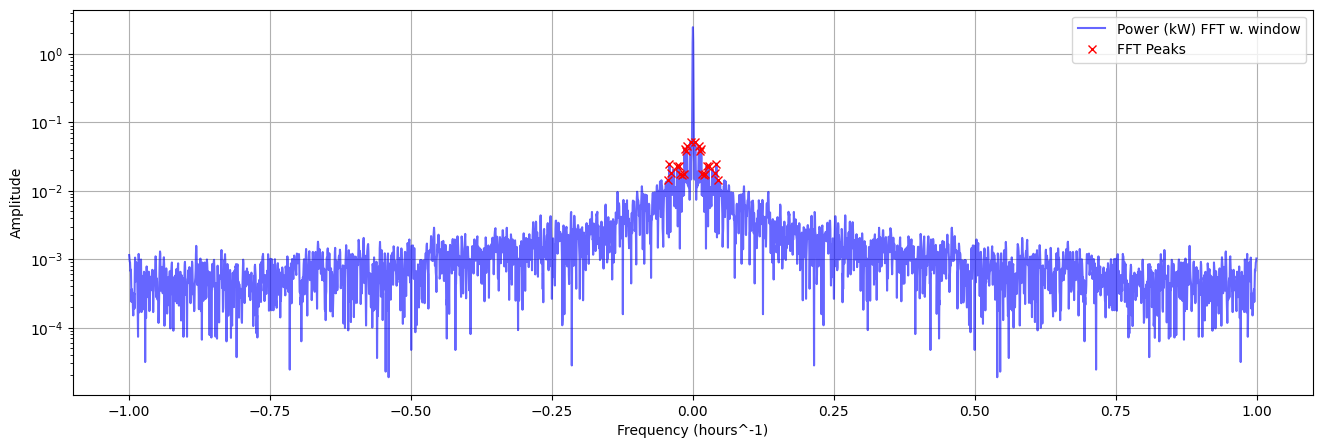

Amplitude at periodicity of 1h: 1.0005153009131358
Amplitude at periodicity of 1d: 0.07147872003183
Amplitude at periodicity of 7d: 0.07147872003183
Amplitude at periodicity of 30d: 0.07147872003183


In [2]:
# average time difference between each sample
T = np.mean([(dl1.index[i+1] - dl1.index[i]).seconds/3600 for i in range(len(dl1) - 1)]) 
N = len(dl1)

# obtain FFT using BLACKMAN window 
dl1_fft = fft.fft(np.array(dl1[HEADER])*sig.windows.blackman(len(dl1)))
dl1_freqs = fft.fftfreq(N, T)

# find peaks
fft_peaks, _ = sig.find_peaks(np.abs(dl1_fft), threshold=10)

plt.figure(figsize=FIGSIZE)
plt.plot(fft.fftshift(dl1_freqs), 1.0/N*np.abs(fft.fftshift(dl1_fft)), '-b', alpha=0.6, label=HEADER+' FFT w. window')
plt.plot(dl1_freqs[fft_peaks], 1.0/N*np.abs(dl1_fft)[fft_peaks], 'xr', label='FFT Peaks')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (hours^-1)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.grid()
plt.show()

timeframes = ['1h', '1d', '7d', '30d']
for timeframe in timeframes:
    hour = my.Timedelta_to_hour(timeframe)
    freq = 1/hour
    amplitude_at_closest, idx = my.find_nearest(np.abs(dl1_fft), freq)
    print(f'Amplitude at periodicity of {timeframe}: {amplitude_at_closest}')

## Autocorrelation and PSD
It's important to remember this is a stochastic random process. As such, we can plot the autocorrelation function and its power spectral density (PSD), allowing us to make a more accurate statement on how power is distributed in each frequency. We will use SciPy's [Welch Approximation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html), as well as Pandas's [autocorr() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html)

Autocorrelation for Lag 1: 0.9787304367612458
Maximum Autocorrelation (dB): 44.93032281224429
Times where a peak occurs: [Timedelta('5 days 08:00:00'), Timedelta('1 days 01:36:00'), Timedelta('0 days 16:00:00'), Timedelta('0 days 12:48:00'), Timedelta('0 days 09:50:46.153846154'), Timedelta('0 days 06:24:00')]
Peak Amplitudes: [44.93032281224429, 38.49016526251062, 33.233125258247924, 32.853124917080365, 31.720452166633937, 26.549453423991388]


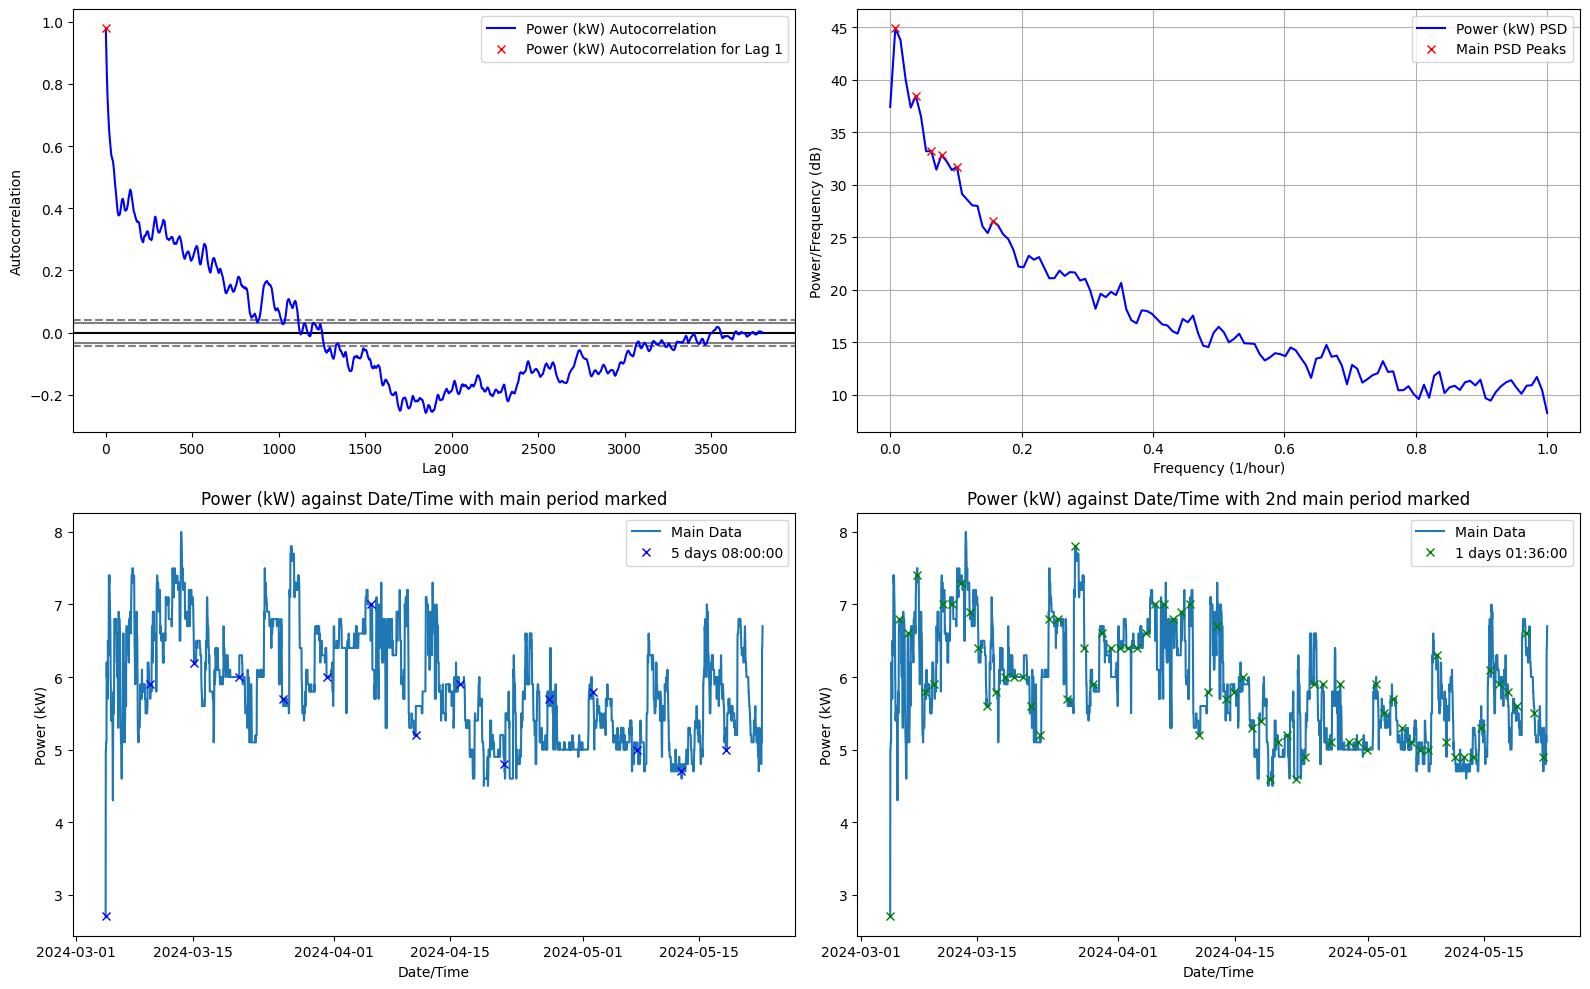

In [3]:
time_periods = my.autocorr_and_psd_analysis(dl1[HEADER], header=HEADER, peaks_height=25, double_sided=False)